In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex1 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/store-sales-time-series-forecasting')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [6]:
book_sales.head()

,Hardcover,Time,Lag_1
Date,,,
2000-04-01,139,0,NaN
2000-04-02,128,1,139.0
2000-04-03,172,2,128.0
2000-04-04,139,3,172.0
2000-04-05,191,4,139.0


In [7]:
ar.head()

,ar1,ar2
0,0.541286,-1.234475
1,-1.692950,3.532498
2,-1.730106,-3.915508
3,-0.783524,2.820841
4,-1.796207,-1.084120


--------------------------------------------------------------------------------

One advantage linear regression has over more complicated algorithms is that the models it creates are *explainable* -- it's easy to interpret what contribution each feature makes to the predictions. In the model `target = weight * feature + bias`, the `weight` tells you by how much the `target` changes on average for each unit of change in the `feature`.

Run the next cell to see a linear regression on *Hardcover Sales*.

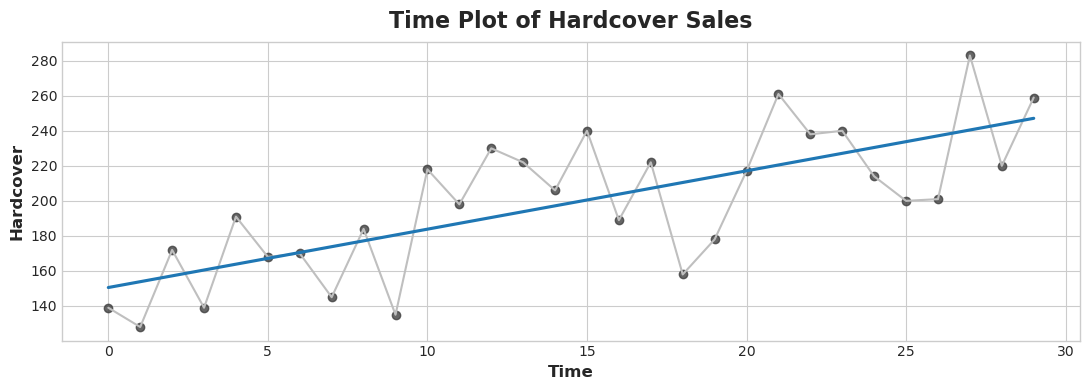

In [2]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data = book_sales, color = '0.75')
ax = sns.regplot(x='Time', y='Hardcover', data = book_sales, ci = None, scatter_kws = dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

# 1) Interpret linear regression with the time dummy

The linear regression line has an equation of (approximately) `Hardcover = 3.33 * Time + 150.5`. Over 6 days how much on average would you expect hardcover sales to change? After you've thought about it, run the next cell.

In [3]:
# View the solution (Run this line to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

A change of 6 steps in `Time` corresponds to an average change of 6 * 3.33 = 19.98 in `Hardcover` sales.


In [4]:
# Uncomment the next line for a hint
q_1.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Do you remember the slope-intercept equation of a line? The slope is 3.33, so `Hardcover` will change on average by 3.33 units for every 1 step change in `Time`, according to this model.


-------------------------------------------------------------------------------

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where `error` is random noise and `weight` is a number between -1 and 1. The `weight` in this case tells you how likely the next time step will have the same sign as the previous time step: a `weight` close to 1 means `target` will likely have the same sign as the previous step, while a `weight` close to -1 means `target` will likely have the opposite sign.

# 2) Interpret linear regression with a lag feature

Run the following cell to see two series generated according to the model just described.

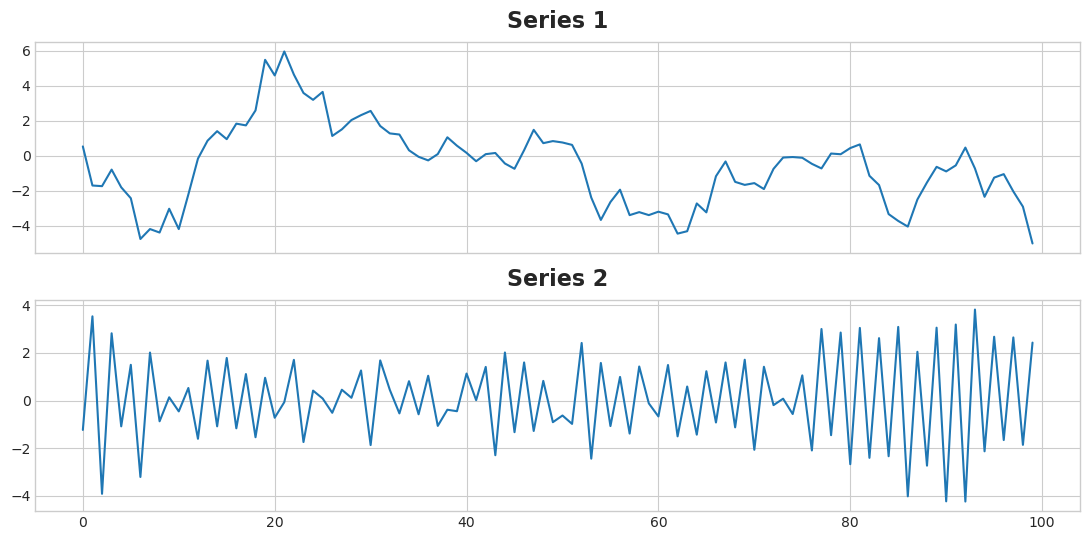

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

One of these series has the equation `target = 0.95 * lag_1 + error` and the other has the equation `target = -0.95 * lag_1 + error`, differing only by the sign on the lag feature. Can you tell which equation goes with each series?

In [8]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

**Series 1** was generated by `target = 0.95 * lag_1 + error` and **Series 2** was generated by `target = -0.95 * lag_1 + error`.


In [9]:
# Uncomment the next line for a hint
q_2.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> The series with the 0.95 weight will tend to have values with signs that stay the same. The series with the -0.95 weight will tend to have values with signs that change back and forth.


-------------------------------------------------------------------------------

Now we'll get started with the *Store Sales - Time Series Forecasting* competition data. The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. For this lesson, we'll just work with a single series (`average_sales`) of the average sales each day.

# 3) Fit a time-step feature

Complete the code below to create a linear regression model with a time-step feature on the series of average product sales. The target is in a column called `'sales'`.

In [13]:
average_sales.to_frame()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390808
2013-01-03,202.840195
2013-01-04,198.911148
2013-01-05,267.873230
...,...
2017-08-11,463.733856
2017-08-12,444.798279
2017-08-13,485.768616


In [14]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index))

In [17]:
time, df.shape

(array([   0,    1,    2, ..., 1681, 1682, 1683]), (1684, 1))

In [22]:
df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:, ['time']]  # features
y = df['sales'] # target

In [23]:
X

,time
date,
2013-01-01,0
2013-01-02,1
2013-01-03,2
2013-01-04,3
2013-01-05,4
...,...
2017-08-11,1679
2017-08-12,1680
2017-08-13,1681


In [24]:
# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Run this cell if you'd like to see a plot of the result.

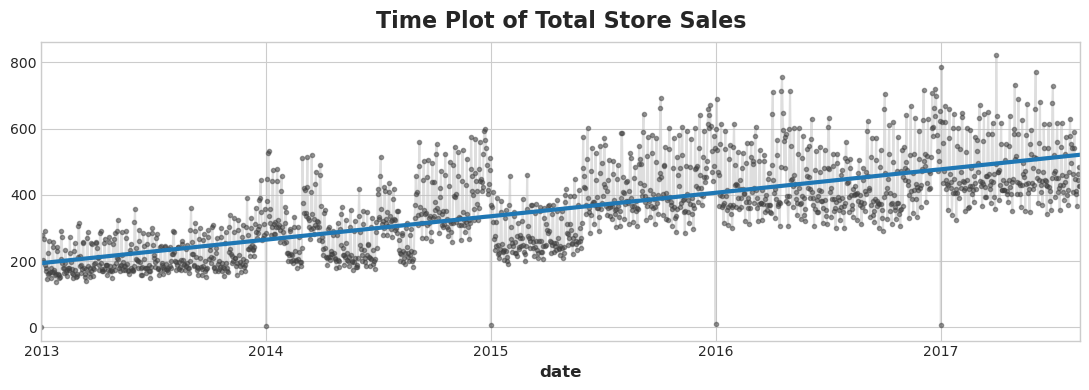

In [26]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

-------------------------------------------------------------------------------

# 4) Fit a lag feature to Store Sales

Complete the code below to create a linear regression model with a lag feature on the series of average product sales. The target is in a column of `df` called `'sales'`.

In [28]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join = 'inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)
# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index = X.index)


# Check your answer
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Run the next cell if you'd like to see the result.

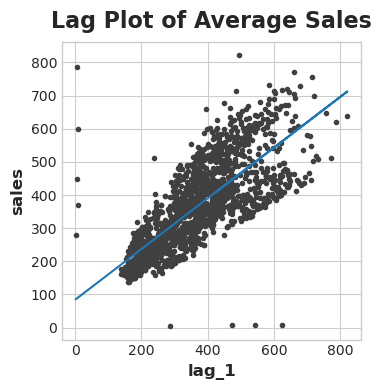

In [30]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');